In [81]:
import keras
import tensorflow as tf
from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Flatten, Concatenate, Lambda, Dot, Conv2D
from keras.optimizers import Adam
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import numpy as np
import random
from matplotlib import pyplot as plt

In [82]:
# load mnist data set and split it for 3 sets
(X_train, y_train), (X_verif, y_verif) = mnist.load_data()
X_valid, X_test, y_valid, y_test = train_test_split(X_verif, y_verif, test_size=0.5, random_state=42)

In [83]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')

In [84]:
# Normalize the value range
X_train /= 255
X_valid /= 255
X_test /= 255

In [85]:
# Generate pairs of images that are the same class or a different one
def generate_pairs(X, y):
    number_classes = max(y) + 1
    digit_inidices = [np.where(y == i)[0] for i in range(number_classes)]
    
    pairs = []
    labels = []
    
    for idx1 in range(len(X)):
        # example that matches
        X1 = X[idx1]
        y1 = y[idx1]
        idx2 = random.choice(digit_inidices[y1])
        X2 = X[idx2]
        pairs.append([X1, X2])
        labels.append(1)
        
        # example that does not match
        y2 = random.randint(0, number_classes - 1)
        while y1 == y2:
            y2 = random.randint(0, number_classes - 1)
            
        idx2 = random.choice(digit_inidices[y2])
        X2 = X[idx2]
        pairs.append([X1, X2])
        labels.append(0)
        
    return np.array(pairs), np.array(labels)

In [86]:
pairs_train, labels_train = generate_pairs(X_train, y_train)
pairs_valid, labels_valid = generate_pairs(X_test, y_test)
pairs_test, labels_test = generate_pairs(X_test, y_test)

Same: False
Same: True
Same: True


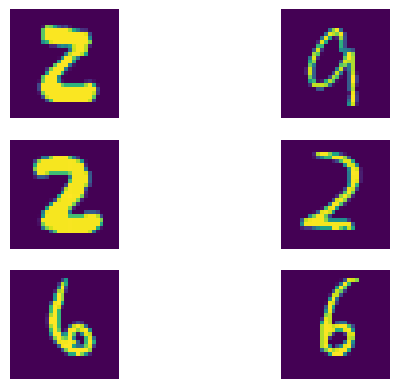

In [88]:
# Show three random examples with their labels
samples = random.sample(range(0, pairs_train.shape[0]), 3)

fig, axar = plt.subplots(3, 2)

for idx, sample in enumerate(samples):
    axar[idx, 0].imshow(pairs_train[sample, 0])
    axar[idx, 0].axis(False)
    axar[idx, 1].imshow(pairs_train[sample, 1])
    axar[idx, 1].axis(False)
    print("Same:", bool(labels_train[samples[idx]]))


## Convolution network model without shared weights

In [89]:
# Creating two networks each with their own weights. 
# The architecture is inspired by LeNet-5 by LeCun, Bottou, Bengio, and Haffner
siam_net_1 = keras.Sequential(name='siamese-part1')
siam_net_1.add(keras.layers.Input(shape=(28, 28, 1)))
siam_net_1.add(keras.layers.Conv2D(input_shape=(28, 28, 1), filters= 6, kernel_size = (5, 5), 
                                    padding= 'same', activation='relu', data_format="channels_last"))
siam_net_1.add(keras.layers.Conv2D(filters= 16, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_1.add(keras.layers.Conv2D(filters= 120, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_1.add(keras.layers.Flatten())

siam_net_2 = keras.Sequential(name='siamese-part2')
siam_net_2.add(keras.layers.Input(shape=(28, 28, 1)))
siam_net_2.add(keras.layers.Conv2D(input_shape=(28, 28, 1), filters= 6, kernel_size = (5, 5), 
                                    padding= 'same', activation='relu', data_format="channels_last"))
siam_net_2.add(keras.layers.Conv2D(filters= 16, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_2.add(keras.layers.Conv2D(filters= 120, kernel_size = (5, 5), 
                                padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_2.add(keras.layers.Flatten())

# The output of the two siamese networks is flattened, concatenated, and then passed to a logistic layer
merge_layer = keras.layers.Concatenate()([siam_net_1.output, siam_net_2.output])
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(merge_layer)
mod_seperate_weights = keras.Model(name="split_concatenated",inputs=[siam_net_1.input, siam_net_2.input], 
                             outputs=output_layer)

In [90]:
mod_seperate_weights.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

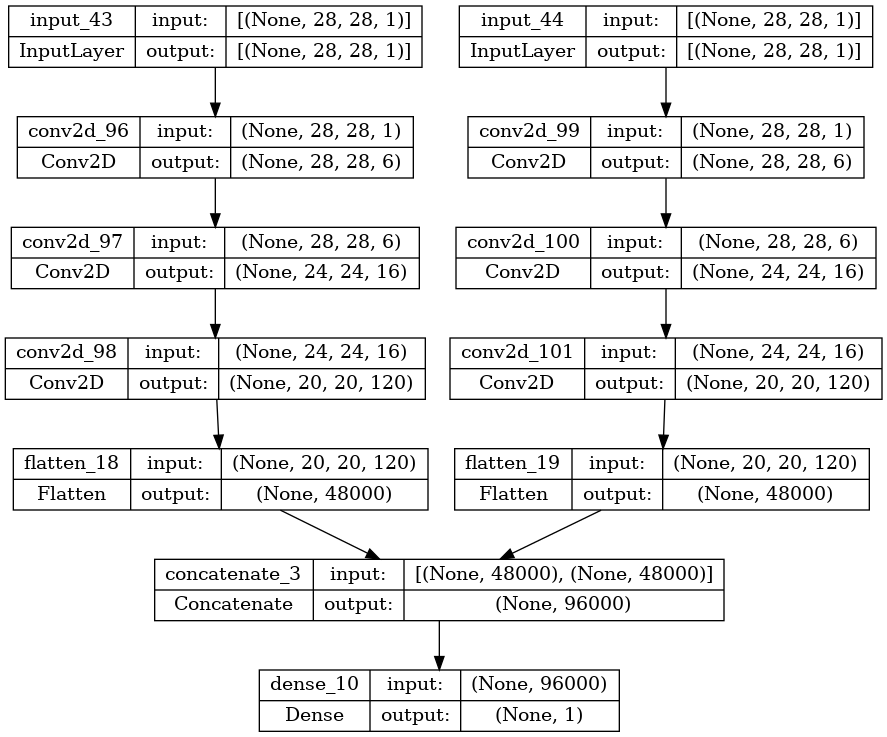

In [91]:
plot_model(mod_seperate_weights, show_shapes=True, show_layer_names=True)

In [30]:
mod_seperate_weights.fit(x=[pairs_train[:,0].reshape(-1 ,28 , 28, 1), pairs_train[:,1].reshape(-1 ,28 , 28, 1)], 
                        y=labels_train.reshape(-1,1), batch_size=16, epochs=1)

2023-06-25 21:18:27.543493: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.
2023-06-25 21:18:29.969019: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 376320000 exceeds 10% of free system memory.


   2/7500 [..............................] - ETA: 11:50 - loss: 0.7233 - accuracy: 0.2500  

2023-06-25 21:18:33.625668: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27993600 exceeds 10% of free system memory.
2023-06-25 21:18:33.634566: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27993600 exceeds 10% of free system memory.
2023-06-25 21:18:33.644151: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27993600 exceeds 10% of free system memory.


 102/7500 [..............................] - ETA: 10:42 - loss: 0.6938 - accuracy: 0.5012

KeyboardInterrupt: 

In [31]:
mod_seperate_weights.evaluate(x=[pairs_valid[:,0].reshape(-1, 28, 28, 1), pairs_valid[:,1].reshape(-1, 28, 28, 1)], 
                              y=labels_valid.reshape(-1, 1), batch_size=16)

625/625 [==============================] - 17s 27ms/step - loss: 0.6932 - accuracy: 0.5006


[0.6931576728820801, 0.5005999803543091]

## Introducing the euclidean distance / L2-Norm

In [92]:
# Required to calculate the difference between two outputs
def eukledian_distance(input_vector):
    y_1, y_2 = input_vector
    summed_square = tf.math.reduce_sum(tf.square(y_1 - y_2), axis=1 ,keepdims=True)
    return tf.sqrt(tf.math.maximum(summed_square, keras.backend.epsilon()))

In [93]:
siam_net_1 = keras.Sequential(name='siamese-part1')
siam_net_1.add(keras.layers.Input(shape=(28, 28, 1)))
siam_net_1.add(keras.layers.Conv2D(input_shape=(28, 28, 1), filters= 6, kernel_size = (5, 5), 
                                    padding= 'same', activation='relu', data_format="channels_last"))
siam_net_1.add(keras.layers.Conv2D(filters= 16, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_1.add(keras.layers.Conv2D(filters= 120, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))

siam_net_2 = keras.Sequential(name='siamese-part2')
siam_net_2.add(keras.layers.Input(shape=(28, 28, 1)))
siam_net_2.add(keras.layers.Conv2D(input_shape=(28, 28, 1), filters= 6, kernel_size = (5, 5), 
                                    padding= 'same', activation='relu', data_format="channels_last"))
siam_net_2.add(keras.layers.Conv2D(filters= 16, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))
siam_net_2.add(keras.layers.Conv2D(filters= 120, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last"))

# The output of the two siamese networks is flattened, euclidean distance applied, 
# and then passed to a logistic layer
merge_layer = keras.layers.Lambda(eukledian_distance)([siam_net_1.layers[2].output, siam_net_2.layers[2].output])
flatten_layer = keras.layers.Flatten()(merge_layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(flatten_layer)
mod_seperate_weights_l2 = keras.Model(name="split_l2_norm",inputs=[siam_net_1.input, siam_net_2.input], 
                             outputs=output_layer)

In [94]:
mod_seperate_weights_l2.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

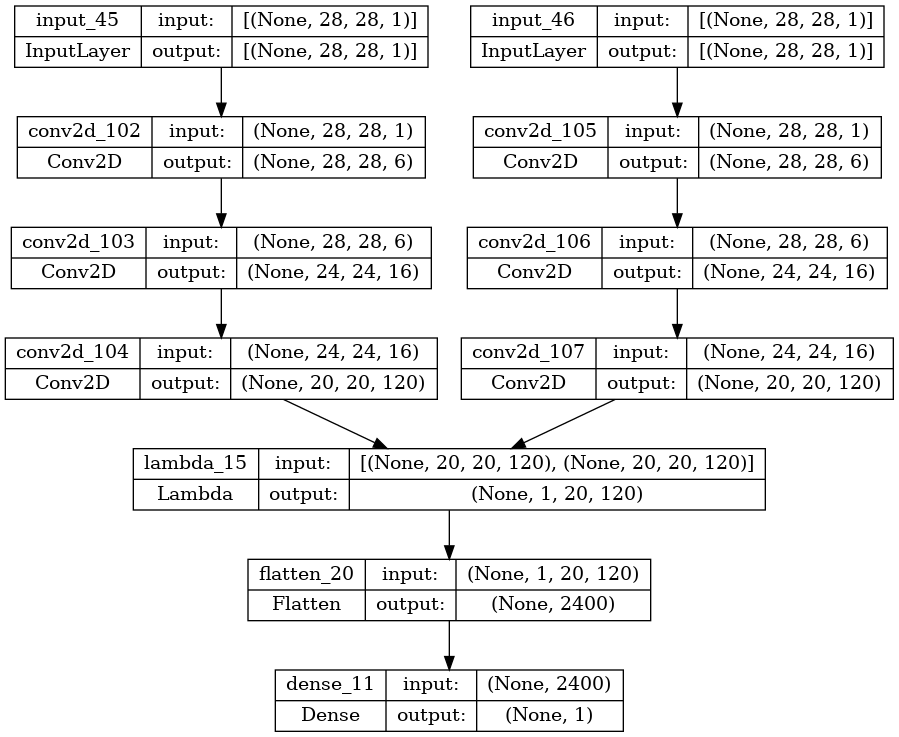

In [95]:
plot_model(mod_seperate_weights_l2, show_shapes=True, show_layer_names=True)

In [68]:
mod_seperate_weights_l2.fit(x=[pairs_train[:,0].reshape(-1 ,28 , 28, 1), pairs_train[:,1].reshape(-1 ,28 , 28, 1)], 
                         y=labels_train.reshape(-1,1), batch_size=16, epochs=1)

   8/7500 [..............................] - ETA: 15:31 - loss: 0.6837 - accuracy: 0.5938

KeyboardInterrupt: 

In [46]:
mod_seperate_weights_l2.evaluate(x=[pairs_valid[:,0].reshape(-1, 28, 28, 1), pairs_valid[:,1].reshape(-1, 28, 28, 1)], 
                                  y=labels_valid.reshape(-1, 1), batch_size=16)

625/625 [==============================] - 15s 23ms/step - loss: 0.1556 - accuracy: 0.9434


[0.1556173413991928, 0.9434000253677368]

## Further improve by introducing shared weights

In [96]:
input_layer = keras.layers.Input(shape=(28, 28, 1))
conv2_layer_1 = keras.layers.Conv2D(input_shape=(28, 28, 1), filters= 6, kernel_size = (5, 5), 
                                    padding= 'same', activation='relu', data_format="channels_last")(input_layer)
pool_layer_1 = keras.layers.MaxPool2D()(conv2_layer_1)
conv2_layer_2 = keras.layers.Conv2D(filters= 16, kernel_size = (5, 5), 
                                    padding= 'valid', activation='relu', data_format="channels_last")(pool_layer_1)
pool_layer_2 = keras.layers.MaxPool2D()(conv2_layer_2)
nn_arch = keras.layers.Conv2D(filters= 120, kernel_size = (5, 5), 
                                padding= 'valid', activation='relu', data_format="channels_last")(pool_layer_2)

mod_shared_weights = keras.Model(input_layer, nn_arch)

In [97]:
input_1 = keras.layers.Input(shape=(28, 28, 1))
input_2 = keras.layers.Input(shape=(28, 28, 1))

siam_part_1 = mod_shared_weights(input_1)
siam_part_2 = mod_shared_weights(input_2)

merge_layer = keras.layers.Lambda(eukledian_distance)([siam_part_1, siam_part_2])
flatten_layer = keras.layers.Flatten()(merge_layer)
output_layer = keras.layers.Dense(units=1, activation='sigmoid')(flatten_layer)
mod_siam_network = keras.Model(name="siamese-network", inputs=[input_1, input_2], outputs=output_layer)

In [98]:
mod_siam_network.compile(optimizer='adam', loss=keras.losses.binary_crossentropy, metrics=["accuracy"])

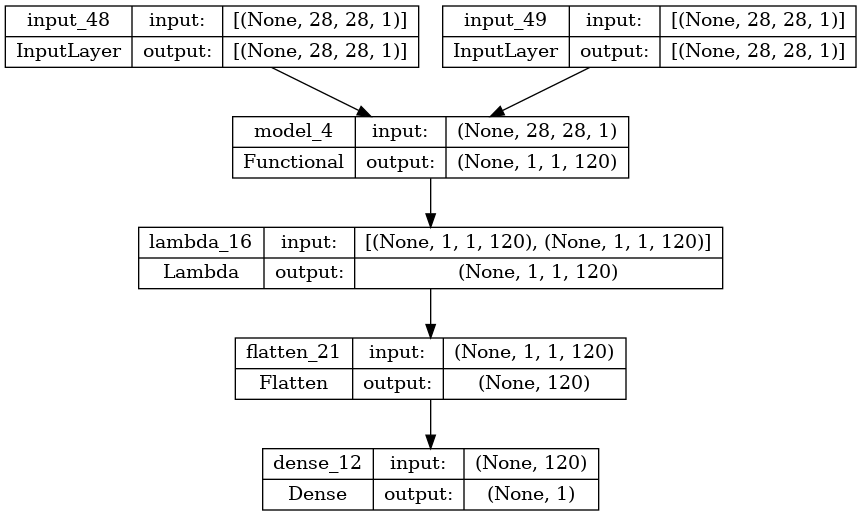

In [99]:
plot_model(mod_siam_network, show_shapes=True, show_layer_names=True)

In [51]:
mod_siam_network.fit(x=[pairs_train[:,0].reshape(-1 ,28 , 28, 1), pairs_train[:,1].reshape(-1 ,28 , 28, 1)], 
                        y=labels_train.reshape(-1,1), batch_size=16, epochs=1)

7500/7500 [==============================] - 119s 16ms/step - loss: 0.1497 - accuracy: 0.9405


In [52]:
mod_siam_network.evaluate(x=[pairs_valid[:,0].reshape(-1, 28, 28, 1), pairs_valid[:,1].reshape(-1, 28, 28, 1)], 
                            y=labels_valid.reshape(-1, 1), batch_size=16)

625/625 [==============================] - 4s 7ms/step - loss: 0.0691 - accuracy: 0.9761


[0.06905034929513931, 0.9761000275611877]

In [60]:
mod_siam_network.evaluate(x=[pairs_test[:,0].reshape(-1, 28, 28, 1), pairs_test[:,1].reshape(-1, 28, 28, 1)], 
                            y=labels_test.reshape(-1, 1), batch_size=16)

625/625 [==============================] - 7s 10ms/step - loss: 0.0719 - accuracy: 0.9755


[0.07186350971460342, 0.9754999876022339]

1/1 [==============================] - 0s 30ms/step
Predicted label: 1


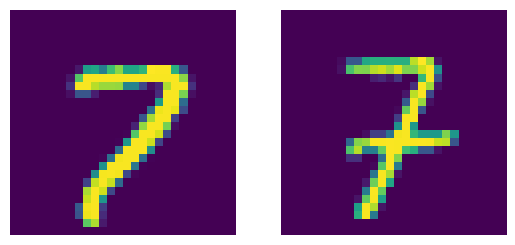

In [59]:
#predict a random sample and show it
random_sample = random.randint(0, pairs_test.shape[0])
prediction = mod_siam_network.predict(x=[pairs_train[random_sample,0].reshape(-1, 28, 28, 1), 
                                             pairs_train[random_sample,1].reshape(-1, 28, 28, 1)])

if prediction > 0.5:
    print("Predicted label: 1")
else:
    print("Predicted label: 0")
    
fig, axar = plt.subplots(1, 2)
for j in range(0, 2):
    axar[j].axis(False)
    
axar[0].imshow(pairs_train[random_sample, 0])
axar[1].imshow(pairs_train[random_sample, 1])
